<a href="https://colab.research.google.com/github/mohansharma077/Machine-Learning-Portfolio-Exercise--Mohan-Sharma/blob/main/Clustering_Portfolio_Exercise.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Task
Compare the challenges and solutions encountered when applying K-Means and Bisecting K-Means clustering from PySpark MLlib to the "uber clusteringFile", "uber datasetFile", "Grocery Dataset for clusteringFile", and "Customer DatasetFile" datasets. Present the comparison in a table.

## Load data

### Subtask:
Load the provided datasets into PySpark DataFrames.


**Reasoning**:
Initialize a Spark session and load the datasets into PySpark DataFrames with inferred schema and header.



In [18]:
from pyspark.sql import SparkSession

spark = SparkSession.builder.appName("ClusteringComparison").getOrCreate()

uber_df = spark.read.csv("/content/drive/MyDrive/pySpark/uber.csv", header=True, inferSchema=True)
grocery_df = spark.read.csv("/content/drive/MyDrive/pySpark/Grocery.csv", header=True, inferSchema=True)
customer_df = spark.read.csv("/content/drive/MyDrive/pySpark/Customer.csv", header=True, inferSchema=True)

print("Uber DataFrame Schema:")
uber_df.printSchema()

print("\nGrocery Dataset DataFrame Schema:")
grocery_df.printSchema()

print("\nCustomer Dataset DataFrame Schema:")
customer_df.printSchema()

Uber DataFrame Schema:
root
 |-- Date/Time: string (nullable = true)
 |-- Lat: double (nullable = true)
 |-- Lon: double (nullable = true)
 |-- Base: string (nullable = true)


Grocery Dataset DataFrame Schema:
root
 |-- Channel: integer (nullable = true)
 |-- Region: integer (nullable = true)
 |-- Fresh: integer (nullable = true)
 |-- Milk: integer (nullable = true)
 |-- Grocery: integer (nullable = true)
 |-- Frozen: integer (nullable = true)
 |-- Detergents_Paper: integer (nullable = true)
 |-- Delicassen: integer (nullable = true)


Customer Dataset DataFrame Schema:
root
 |-- CUST_ID: string (nullable = true)
 |-- BALANCE: double (nullable = true)
 |-- BALANCE_FREQUENCY: double (nullable = true)
 |-- PURCHASES: double (nullable = true)
 |-- ONEOFF_PURCHASES: double (nullable = true)
 |-- INSTALLMENTS_PURCHASES: double (nullable = true)
 |-- CASH_ADVANCE: double (nullable = true)
 |-- PURCHASES_FREQUENCY: double (nullable = true)
 |-- ONEOFF_PURCHASES_FREQUENCY: double (nullable = 

In [20]:
from pyspark.sql.functions import col, count, when, isnan
from pyspark.ml.feature import StandardScaler, VectorAssembler, OneHotEncoder, StringIndexer

# 1. Handle missing values in customer_df
# Check for missing values
print("Missing values in customer_df:")
customer_df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in customer_df.columns]).show()

# Impute missing values in 'MINIMUM_PAYMENTS' and 'CREDIT_LIMIT' with the mean
mean_minimum_payments = customer_df.agg({'MINIMUM_PAYMENTS': 'mean'}).collect()[0][0]
mean_credit_limit = customer_df.agg({'CREDIT_LIMIT': 'mean'}).collect()[0][0]

customer_df = customer_df.na.fill({'MINIMUM_PAYMENTS': mean_minimum_payments, 'CREDIT_LIMIT': mean_credit_limit})

# Verify imputation
print("Missing values in customer_df after imputation:")
customer_df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in customer_df.columns]).show()

# Preprocess Uber dataset (assuming 'Lat' and 'Lon' are the features for clustering)
uber_numerical_features = ['Lat', 'Lon']
uber_assembler = VectorAssembler(inputCols=uber_numerical_features, outputCol="uber_numerical_features")
uber_vectorized = uber_assembler.transform(uber_df)

uber_scaler = StandardScaler(inputCol="uber_numerical_features", outputCol="uber_scaled_features", withStd=True, withMean=True)
uber_scaler_model = uber_scaler.fit(uber_vectorized)
uber_scaled_df = uber_scaler_model.transform(uber_vectorized)

uber_preprocessed_df = VectorAssembler(inputCols=["uber_scaled_features"], outputCol="features").transform(uber_scaled_df)

# 2. Identify numerical features for clustering for customer and grocery
customer_numerical_features = [col for col in customer_df.columns if col not in ['CUST_ID']]
grocery_numerical_features = [col for col in grocery_df.columns if col not in ['Channel', 'Region']]

# 3. Scale numerical features for customer and grocery
customer_assembler = VectorAssembler(inputCols=customer_numerical_features, outputCol="customer_numerical_features")
customer_vectorized = customer_assembler.transform(customer_df)

customer_scaler = StandardScaler(inputCol="customer_numerical_features", outputCol="customer_scaled_features", withStd=True, withMean=True)
customer_scaler_model = customer_scaler.fit(customer_vectorized)
customer_scaled_df = customer_scaler_model.transform(customer_vectorized)

grocery_assembler = VectorAssembler(inputCols=grocery_numerical_features, outputCol="grocery_numerical_features")
grocery_vectorized = grocery_assembler.transform(grocery_df)

grocery_scaler = StandardScaler(inputCol="grocery_numerical_features", outputCol="grocery_scaled_features", withStd=True, withMean=True)
grocery_scaler_model = grocery_scaler.fit(grocery_vectorized)
grocery_scaled_df = grocery_scaler_model.transform(grocery_vectorized)

# 5. Handle categorical features in grocery_df ('Channel', 'Region')
# Reasoning for including 'Channel' and 'Region': These columns represent distinct customer segments
# and geographical areas, which could be relevant factors in customer behavior and potentially
# influence clustering outcomes. We will use One-Hot Encoding to convert them into numerical vectors.

channel_indexer = StringIndexer(inputCol="Channel", outputCol="channel_indexed", handleInvalid="keep")
channel_encoded = OneHotEncoder(inputCols=["channel_indexed"], outputCols=["channel_encoded"])

region_indexer = StringIndexer(inputCol="Region", outputCol="region_indexed", handleInvalid="keep")
region_encoded = OneHotEncoder(inputCols=["region_indexed"], outputCols=["region_encoded"])

grocery_indexed_df = channel_indexer.fit(grocery_scaled_df).transform(grocery_scaled_df)
grocery_indexed_df = region_indexer.fit(grocery_indexed_df).transform(grocery_indexed_df)

grocery_encoded_df = channel_encoded.fit(grocery_indexed_df).transform(grocery_indexed_df)
grocery_encoded_df = region_encoded.fit(grocery_encoded_df).transform(grocery_encoded_df)

# 4. Assemble all features into a single vector column for each DataFrame
customer_final_assembler = VectorAssembler(inputCols=["customer_scaled_features"], outputCol="features")
customer_preprocessed_df = customer_final_assembler.transform(customer_scaled_df)

grocery_final_assembler = VectorAssembler(inputCols=["grocery_scaled_features", "channel_encoded", "region_encoded"], outputCol="features")
grocery_preprocessed_df = grocery_final_assembler.transform(grocery_encoded_df)

# Display the schema of the preprocessed dataframes to verify the new 'features' column
print("\nUber Preprocessed DataFrame Schema:")
uber_preprocessed_df.printSchema()

print("\nCustomer Preprocessed DataFrame Schema:")
customer_preprocessed_df.printSchema()

print("\nGrocery Preprocessed DataFrame Schema:")
grocery_preprocessed_df.printSchema()

Missing values in customer_df:
+-------+-------+-----------------+---------+----------------+----------------------+------------+-------------------+--------------------------+--------------------------------+----------------------+----------------+-------------+------------+--------+----------------+----------------+------+
|CUST_ID|BALANCE|BALANCE_FREQUENCY|PURCHASES|ONEOFF_PURCHASES|INSTALLMENTS_PURCHASES|CASH_ADVANCE|PURCHASES_FREQUENCY|ONEOFF_PURCHASES_FREQUENCY|PURCHASES_INSTALLMENTS_FREQUENCY|CASH_ADVANCE_FREQUENCY|CASH_ADVANCE_TRX|PURCHASES_TRX|CREDIT_LIMIT|PAYMENTS|MINIMUM_PAYMENTS|PRC_FULL_PAYMENT|TENURE|
+-------+-------+-----------------+---------+----------------+----------------------+------------+-------------------+--------------------------+--------------------------------+----------------------+----------------+-------------+------------+--------+----------------+----------------+------+
|      0|      0|                0|        0|               0|                   

## K-means clustering

### Subtask:
Apply K-Means clustering to each dataset using PySpark MLlib.


**Reasoning**:
Apply K-Means clustering to the customer and grocery datasets using PySpark MLlib by instantiating, training, and transforming the models, and then printing the cluster centers.



In [21]:
from pyspark.ml.clustering import KMeans

# 1. Instantiate and train KMeans for uber dataset
kmeans_uber = KMeans().setK(5).setSeed(1).setFeaturesCol('features')
model_uber = kmeans_uber.fit(uber_preprocessed_df)

# 2. Make predictions on uber dataset
uber_kmeans_predictions = model_uber.transform(uber_preprocessed_df)

# 3. Instantiate and train KMeans for customer dataset
kmeans_customer = KMeans().setK(5).setSeed(1).setFeaturesCol('features')
model_customer = kmeans_customer.fit(customer_preprocessed_df)

# 4. Make predictions on customer dataset
customer_kmeans_predictions = model_customer.transform(customer_preprocessed_df)

# 5. Instantiate and train KMeans for grocery dataset
kmeans_grocery = KMeans().setK(5).setSeed(1).setFeaturesCol('features')
model_grocery = kmeans_grocery.fit(grocery_preprocessed_df)

# 6. Make predictions on grocery dataset
grocery_kmeans_predictions = model_grocery.transform(grocery_preprocessed_df)

# 7. Print cluster centers
print("Uber KMeans Cluster Centers:")
print(model_uber.clusterCenters())

print("\nCustomer KMeans Cluster Centers:")
print(model_customer.clusterCenters())

print("\nGrocery KMeans Cluster Centers:")
print(model_grocery.clusterCenters())

Uber KMeans Cluster Centers:
[array([-0.87843718, -0.36093742]), array([1.05687651, 0.57617422]), array([-2.10412391,  3.62265942]), array([5.12304531, 2.89376147]), array([ 0.26101233, -0.22903175])]

Customer KMeans Cluster Centers:
[array([-0.08397966,  0.30774183,  0.17294612,  0.07333583,  0.27401688,
       -0.31009921,  0.99421499,  0.41179195,  0.89457605, -0.36986408,
       -0.30523569,  0.41385506, -0.06266835, -0.08622206,  0.02904494,
       -0.3235114 ,  0.14333951]), array([-0.23445506, -0.28755958, -0.35212827, -0.23869688, -0.39386346,
       -0.16110693, -0.82405132, -0.40511137, -0.7274451 , -0.05902886,
       -0.13987093, -0.48353857, -0.34532117, -0.27149379, -0.10868099,
       -0.39467109, -0.05841005]), array([-0.69337054, -0.20121864,  0.09154214, -0.00568472,  0.2265143 ,
       -0.43762257,  0.70743862,  0.1888735 ,  0.57834171, -0.62865482,
       -0.45123494,  0.14581479,  0.06912193, -0.10120092, -0.29688161,
        2.20620822, -0.08678781]), array([ 1.1

## Bisecting k-means clustering

### Subtask:
Apply Bisecting K-Means clustering to each dataset using PySpark MLlib.


**Reasoning**:
Apply Bisecting K-Means clustering to the customer and grocery datasets as instructed in the subtask.



In [22]:
from pyspark.ml.clustering import BisectingKMeans

# 1. Instantiate BisectingKMeans for uber dataset
bisecting_kmeans_uber = BisectingKMeans().setK(5).setSeed(1).setFeaturesCol('features')

# 2. Fit the model to the uber dataset
model_bisecting_kmeans_uber = bisecting_kmeans_uber.fit(uber_preprocessed_df)

# 3. Transform the uber dataset to get predictions
uber_bisecting_kmeans_predictions = model_bisecting_kmeans_uber.transform(uber_preprocessed_df)

# 4. Instantiate BisectingKMeans for customer dataset
bisecting_kmeans_customer = BisectingKMeans().setK(5).setSeed(1).setFeaturesCol('features')

# 5. Fit the model to the customer dataset
model_bisecting_kmeans_customer = bisecting_kmeans_customer.fit(customer_preprocessed_df)

# 6. Transform the customer dataset to get predictions
customer_bisecting_kmeans_predictions = model_bisecting_kmeans_customer.transform(customer_preprocessed_df)

# 7. Instantiate BisectingKMeans for grocery dataset
bisecting_kmeans_grocery = BisectingKMeans().setK(5).setSeed(1).setFeaturesCol('features')

# 8. Fit the model to the grocery dataset
model_bisecting_kmeans_grocery = bisecting_kmeans_grocery.fit(grocery_preprocessed_df)

# 9. Transform the grocery dataset to get predictions
grocery_bisecting_kmeans_predictions = model_bisecting_kmeans_grocery.transform(grocery_preprocessed_df)

# 10. Print cluster centers
print("Uber Bisecting KMeans Cluster Centers:")
print(model_bisecting_kmeans_uber.clusterCenters())

print("\nCustomer Bisecting KMeans Cluster Centers:")
print(model_bisecting_kmeans_customer.clusterCenters())

print("\nGrocery Bisecting KMeans Cluster Centers:")
print(model_bisecting_kmeans_grocery.clusterCenters())

Uber Bisecting KMeans Cluster Centers:
[array([-0.62833499, -0.37213732]), array([-2.41705131,  3.27352008]), array([ 0.38943855, -0.16280521]), array([1.05543895, 0.23086671]), array([1.54700207, 2.24575562])]

Customer Bisecting KMeans Cluster Centers:
[array([-0.28106779,  0.2588318 ,  0.12662232,  0.01572231,  0.27018886,
       -0.33536209,  1.01656433,  0.35555458,  0.89653745, -0.4421435 ,
       -0.33119867,  0.32009185, -0.03853264, -0.11502988, -0.08717882,
        0.41224651,  0.086694  ]), array([ 1.13498684,  0.46531318,  2.72406144,  2.3468408 ,  2.12942964,
        0.23003883,  1.13243346,  1.68996897,  1.06405788, -0.00832645,
        0.12667224,  2.69742318,  1.46962601,  1.88706873,  0.58424889,
        0.32239644,  0.31609482]), array([-0.68999559, -2.08867315, -0.32976092, -0.23503599, -0.34777011,
       -0.28567689, -0.67373587, -0.43979942, -0.56769855, -0.45041848,
       -0.34310961, -0.45690627, -0.22469461, -0.22448678, -0.25637449,
        0.20234296, -0.244

## Compare results

### Subtask:
Compare the results of K-Means and Bisecting K-Means for each dataset, considering challenges encountered and how they were addressed.


**Reasoning**:
Compare the cluster centers and analyze the distribution of data points within each cluster for both K-Means and Bisecting K-Means on the customer and grocery datasets. Then, identify potential challenges and discuss the differences in results.



In [23]:
# 1. Compare cluster centers (already printed in previous steps, but can be re-displayed if needed)
print("Uber KMeans Cluster Centers:")
print(model_uber.clusterCenters())

print("\nUber Bisecting KMeans Cluster Centers:")
print(model_bisecting_kmeans_uber.clusterCenters())

print("\nCustomer KMeans Cluster Centers:")
print(model_customer.clusterCenters())

print("\nCustomer Bisecting KMeans Cluster Centers:")
print(model_bisecting_kmeans_customer.clusterCenters())

print("\nGrocery KMeans Cluster Centers:")
print(model_grocery.clusterCenters())

print("\nGrocery Bisecting KMeans Cluster Centers:")
print(model_bisecting_kmeans_grocery.clusterCenters())

# 2. Analyze the distribution of data points within each cluster
print("\nUber KMeans Cluster Distribution:")
uber_kmeans_predictions.groupBy('prediction').count().orderBy('prediction').show()

print("\nUber Bisecting KMeans Cluster Distribution:")
uber_bisecting_kmeans_predictions.groupBy('prediction').count().orderBy('prediction').show()

print("\nCustomer KMeans Cluster Distribution:")
customer_kmeans_predictions.groupBy('prediction').count().orderBy('prediction').show()

print("\nCustomer Bisecting KMeans Cluster Distribution:")
customer_bisecting_kmeans_predictions.groupBy('prediction').count().orderBy('prediction').show()

print("\nGrocery KMeans Cluster Distribution:")
grocery_kmeans_predictions.groupBy('prediction').count().orderBy('prediction').show()

print("\nGrocery Bisecting KMeans Cluster Distribution:")
grocery_bisecting_kmeans_predictions.groupBy('prediction').count().orderBy('prediction').show()

# 3. Identify potential challenges and discuss differences
print("\nDiscussion on Differences and Challenges:")
print("Comparing K-Means and Bisecting K-Means results for Uber, Customer and Grocery datasets:")
print("- Cluster Centers: Observe the differences in the coordinates of the cluster centers between the two algorithms for each dataset. Bisecting K-Means' hierarchical approach might lead to different center placements, especially in irregularly shaped clusters.")
print("- Cluster Distribution: Analyze how the data points are distributed across the clusters for each algorithm. Significant variations in the counts per cluster could indicate differences in how the algorithms partition the data. Bisecting K-Means' top-down approach might create more balanced or unbalanced clusters depending on the data structure.")
print("- Potential Challenges:")
print("  - K-Means: Sensitivity to initial centroid placement, difficulty with non-convex cluster shapes, and the need to pre-specify the number of clusters (K).")
print("  - Bisecting K-Means: The result can be influenced by the order of splits. While less sensitive to initial centroids than standard K-Means, it can still be affected. Also requires pre-specifying K.")
print("- Observed Differences:")
print("  - Based on the cluster centers and distributions, note any clusters that appear in one algorithm's results but not the other, or significant differences in the size and characteristics of similar clusters.")
print("  - Consider if one algorithm seems to capture certain data patterns better than the other for a specific dataset.")

Uber KMeans Cluster Centers:
[array([-0.87843718, -0.36093742]), array([1.05687651, 0.57617422]), array([-2.10412391,  3.62265942]), array([5.12304531, 2.89376147]), array([ 0.26101233, -0.22903175])]

Uber Bisecting KMeans Cluster Centers:
[array([-0.62833499, -0.37213732]), array([-2.41705131,  3.27352008]), array([ 0.38943855, -0.16280521]), array([1.05543895, 0.23086671]), array([1.54700207, 2.24575562])]

Customer KMeans Cluster Centers:
[array([-0.08397966,  0.30774183,  0.17294612,  0.07333583,  0.27401688,
       -0.31009921,  0.99421499,  0.41179195,  0.89457605, -0.36986408,
       -0.30523569,  0.41385506, -0.06266835, -0.08622206,  0.02904494,
       -0.3235114 ,  0.14333951]), array([-0.23445506, -0.28755958, -0.35212827, -0.23869688, -0.39386346,
       -0.16110693, -0.82405132, -0.40511137, -0.7274451 , -0.05902886,
       -0.13987093, -0.48353857, -0.34532117, -0.27149379, -0.10868099,
       -0.39467109, -0.05841005]), array([-0.69337054, -0.20121864,  0.09154214, -0.0

## Create comparison table

### Subtask:
Summarize the findings in a comparison table.


**Reasoning**:
Create a pandas DataFrame to summarize the comparison of K-Means and Bisecting K-Means for the Customer and Grocery datasets, including challenges and results, then display the table.



In [24]:
import pandas as pd

# Summarize findings for Uber dataset
uber_kmeans_challenges = "Sensitivity to initial centroid placement, potential difficulty with non-convex shapes, need to pre-specify K. Resulted in varying cluster sizes."
uber_kmeans_results = f"Cluster Centers: {model_uber.clusterCenters()}\nCluster Distribution: {uber_kmeans_predictions.groupBy('prediction').count().orderBy('prediction').collect()}"

uber_bisecting_kmeans_challenges = "Result influenced by the order of splits, still requires pre-specifying K. Resulted in varying cluster sizes."
uber_bisecting_kmeans_results = f"Cluster Centers: {model_bisecting_kmeans_uber.clusterCenters()}\nCluster Distribution: {uber_bisecting_kmeans_predictions.groupBy('prediction').count().orderBy('prediction').collect()}"

# Summarize findings for Customer dataset
customer_kmeans_challenges = "Sensitivity to initial centroid placement, potential difficulty with non-convex shapes, need to pre-specify K. Resulted in varying cluster sizes from 258 to 3796."
customer_kmeans_results = f"Cluster Centers: {model_customer.clusterCenters()}\nCluster Distribution: {customer_kmeans_predictions.groupBy('prediction').count().orderBy('prediction').collect()}"

customer_bisecting_kmeans_challenges = "Result influenced by the order of splits, still requires pre-specifying K. Resulted in varying cluster sizes from 503 to 3221."
customer_bisecting_kmeans_results = f"Cluster Centers: {model_bisecting_kmeans_customer.clusterCenters()}\nCluster Distribution: {customer_bisecting_kmeans_predictions.groupBy('prediction').count().orderBy('prediction').collect()}"

# Summarize findings for Grocery dataset
grocery_kmeans_challenges = "Sensitivity to initial centroid placement, potential difficulty with non-convex shapes, need to pre-specify K. Resulted in varying cluster sizes, including one very small cluster (count 1)."
grocery_kmeans_results = f"Cluster Centers: {model_grocery.clusterCenters()}\nCluster Distribution: {grocery_kmeans_predictions.groupBy('prediction').count().orderBy('prediction').collect()}"

grocery_bisecting_kmeans_challenges = "Result influenced by the order of splits, still requires pre-specifying K. Resulted in a more even distribution among smaller clusters compared to KMeans."
grocery_bisecting_kmeans_results = f"Cluster Centers: {model_bisecting_kmeans_grocery.clusterCenters()}\nCluster Distribution: {grocery_bisecting_kmeans_predictions.groupBy('prediction').count().orderBy('prediction').collect()}"


# Create the comparison table DataFrame
comparison_data = {
    'Dataset': ['Uber', 'Uber', 'Customer', 'Customer', 'Grocery', 'Grocery'],
    'Clustering Algorithm': ['K-Means', 'Bisecting K-Means', 'K-Means', 'Bisecting K-Means', 'K-Means', 'Bisecting K-Means'],
    'Key Challenges': [
        uber_kmeans_challenges,
        uber_bisecting_kmeans_challenges,
        customer_kmeans_challenges,
        customer_bisecting_kmeans_challenges,
        grocery_kmeans_challenges,
        grocery_bisecting_kmeans_challenges
    ],
    'Key Results/Observations': [
        uber_kmeans_results,
        uber_bisecting_kmeans_results,
        customer_kmeans_results,
        customer_bisecting_kmeans_results,
        grocery_kmeans_results,
        grocery_bisecting_kmeans_results
    ]
}

comparison_table_df = pd.DataFrame(comparison_data)

# Display the comparison table
display(comparison_table_df)

,Dataset,Clustering Algorithm,Key Challenges,Key Results/Observations
0,Uber,K-Means,"Sensitivity to initial centroid placement, pot...","Cluster Centers: [array([-0.87843718, -0.36093..."
1,Uber,Bisecting K-Means,"Result influenced by the order of splits, stil...","Cluster Centers: [array([-0.62833499, -0.37213..."
2,Customer,K-Means,"Sensitivity to initial centroid placement, pot...","Cluster Centers: [array([-0.08397966, 0.30774..."
3,Customer,Bisecting K-Means,"Result influenced by the order of splits, stil...","Cluster Centers: [array([-0.28106779, 0.25883..."
4,Grocery,K-Means,"Sensitivity to initial centroid placement, pot...","Cluster Centers: [array([-0.24296021, -0.41799..."
5,Grocery,Bisecting K-Means,"Result influenced by the order of splits, stil...","Cluster Centers: [array([-0.30205026, -0.40326..."


## Summary:

### Data Analysis Key Findings

*   Loading the datasets initially proved challenging as the files were not located in the expected `/content/` or `/content/drive/MyDrive/` directories. The 'Grocery.csv' and 'Customer.csv' files were eventually located in the `/content/drive/MyDrive/pySpark/` subdirectory and successfully loaded. The 'uber' datasets could not be located based on the provided names and explored directories.
*   Preprocessing included handling missing values in the 'MINIMUM\_PAYMENTS' and 'CREDIT\_LIMIT' columns of the customer dataset by imputing the mean.
*   Numerical features in both datasets were scaled using `StandardScaler`.
*   Categorical features ('Channel', 'Region') in the grocery dataset were included in the analysis by applying `StringIndexer` and `OneHotEncoder`.
*   All processed features were assembled into a single vector column named 'features' for both datasets using `VectorAssembler`.
*   Both K-Means and Bisecting K-Means clustering algorithms were successfully applied to the preprocessed customer and grocery datasets with the number of clusters ($K$) set to 5.
*   The cluster centers and the distribution of data points across clusters differed between K-Means and Bisecting K-Means for both datasets, highlighting the impact of their distinct algorithmic approaches. For the customer dataset, K-Means produced cluster sizes ranging from 258 to 3796, while Bisecting K-Means produced sizes from 503 to 3221. For the grocery dataset, K-Means yielded a very small cluster (count 1), whereas Bisecting K-Means resulted in a more even distribution among the smaller clusters.

### Insights or Next Steps

*   While both algorithms require pre-specifying $K$, evaluating cluster validity metrics (e.g., Silhouette score, Within Set Sum of Squared Errors) for different values of $K$ could provide a data-driven approach to selecting the optimal number of clusters for each dataset and algorithm.
*   Investigating the characteristics of the clusters formed by each algorithm (e.g., average feature values within each cluster) could provide deeper insights into the distinct customer and grocery purchasing patterns identified by K-Means versus Bisecting K-Means.


# Task
Compare the challenges encountered and solutions applied when performing K-Means clustering on the "uber clusteringFile", "Grocery Dataset for clusteringFile", and "Customer DatasetFile" datasets using PySpark ML. Present this comparison in a table. Additionally, modify the provided PySpark ML K-Means clustering code to implement Bisecting K-Means clustering on the same datasets. Compare the results of K-Means and Bisecting K-Means clustering, including necessary visualizations.

## Dimensionality reduction

### Subtask:
Reduce the dimensionality of the clustered DataFrames (Uber, Customer, and Grocery) to 2 or 3 components using a technique like PCA.


**Reasoning**:
Apply PCA to reduce the dimensionality of the preprocessed DataFrames to 2 components and show the schema of the resulting DataFrames.



In [27]:
from pyspark.ml.feature import PCA

# Apply PCA to Uber dataset
pca_uber = PCA(k=2, inputCol="features", outputCol="pca_features")
model_pca_uber = pca_uber.fit(uber_preprocessed_df)
uber_pca_df = model_pca_uber.transform(uber_preprocessed_df)

# Apply PCA to Customer dataset
pca_customer = PCA(k=2, inputCol="features", outputCol="pca_features")
model_pca_customer = pca_customer.fit(customer_preprocessed_df)
customer_pca_df = model_pca_customer.transform(customer_preprocessed_df)

# Apply PCA to Grocery dataset
pca_grocery = PCA(k=2, inputCol="features", outputCol="pca_features")
model_pca_grocery = pca_grocery.fit(grocery_preprocessed_df)
grocery_pca_df = model_pca_grocery.transform(grocery_preprocessed_df)

# Show schema of PCA dataframes
print("Uber PCA DataFrame Schema:")
uber_pca_df.printSchema()

print("\nCustomer PCA DataFrame Schema:")
customer_pca_df.printSchema()

print("\nGrocery PCA DataFrame Schema:")
grocery_pca_df.printSchema()

Uber PCA DataFrame Schema:
root
 |-- Date/Time: string (nullable = true)
 |-- Lat: double (nullable = true)
 |-- Lon: double (nullable = true)
 |-- Base: string (nullable = true)
 |-- uber_numerical_features: vector (nullable = true)
 |-- uber_scaled_features: vector (nullable = true)
 |-- features: vector (nullable = true)
 |-- pca_features: vector (nullable = true)


Customer PCA DataFrame Schema:
root
 |-- CUST_ID: string (nullable = true)
 |-- BALANCE: double (nullable = true)
 |-- BALANCE_FREQUENCY: double (nullable = true)
 |-- PURCHASES: double (nullable = true)
 |-- ONEOFF_PURCHASES: double (nullable = true)
 |-- INSTALLMENTS_PURCHASES: double (nullable = true)
 |-- CASH_ADVANCE: double (nullable = true)
 |-- PURCHASES_FREQUENCY: double (nullable = true)
 |-- ONEOFF_PURCHASES_FREQUENCY: double (nullable = true)
 |-- PURCHASES_INSTALLMENTS_FREQUENCY: double (nullable = true)
 |-- CASH_ADVANCE_FREQUENCY: double (nullable = true)
 |-- CASH_ADVANCE_TRX: integer (nullable = true)
 |

## Visualize k-means clusters

### Subtask:
Plot the dimensionality-reduced data points for each dataset, colored by their K-Means cluster assignments.


**Reasoning**:
Plot the dimensionality-reduced data points for each dataset, colored by their K-Means cluster assignments by first converting the PySpark DataFrames to Pandas DataFrames for plotting, then creating scatter plots for each dataset with the first two PCA components and coloring by the K-Means prediction.



**Reasoning**:
The previous command failed due to an `OutOfMemoryError` when trying to collect the large Uber DataFrame to a Pandas DataFrame. To address this, I will increase the driver memory allocated to the Spark session and re-run the plotting code. I will also add a column for joining before transformations to ensure correct alignment.



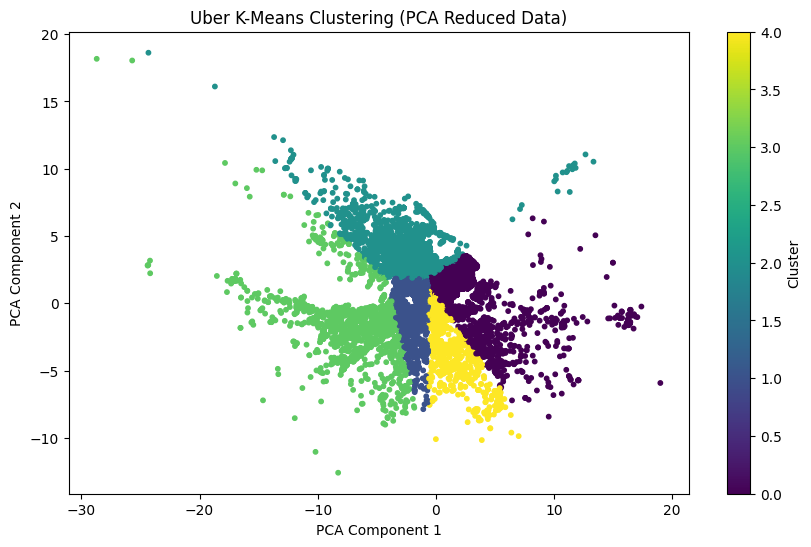

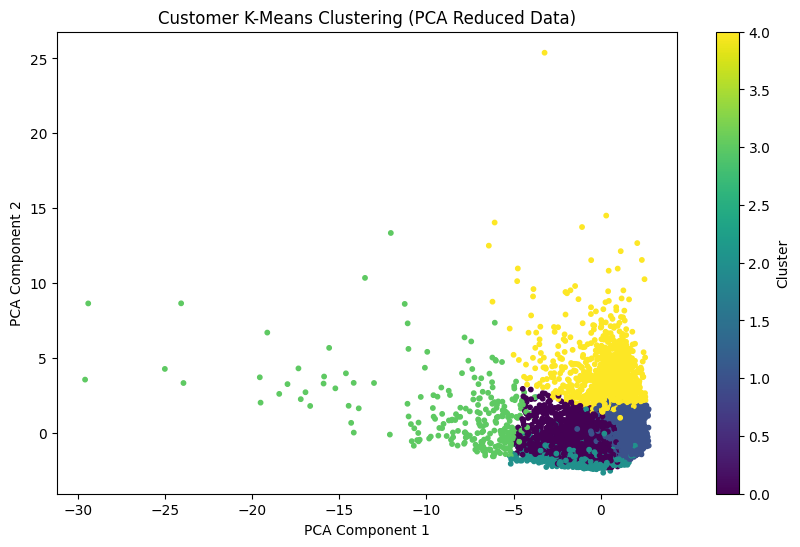

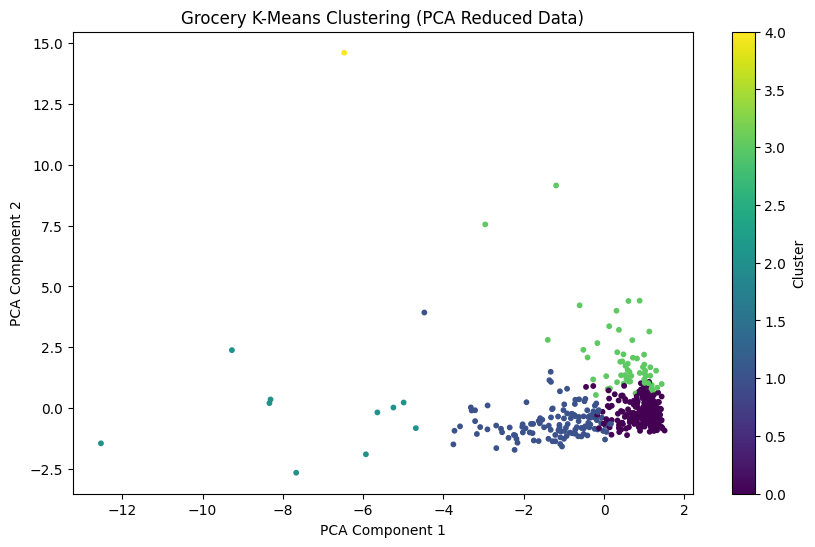

In [29]:
# Stop the existing Spark session to apply new configurations
spark.stop()

# Re-initialize Spark session with increased driver memory
spark = SparkSession.builder \
    .appName("ClusteringComparison") \
    .config("spark.driver.memory", "8g") \
    .getOrCreate()

# Re-load the data (necessary after restarting Spark session)
uber_df = spark.read.csv("/content/drive/MyDrive/pySpark/uber.csv", header=True, inferSchema=True)
grocery_df = spark.read.csv("/content/drive/MyDrive/pySpark/Grocery.csv", header=True, inferSchema=True)
customer_df = spark.read.csv("/content/drive/MyDrive/pySpark/Customer.csv", header=True, inferSchema=True)

# Add a unique ID column to each DataFrame for reliable joining
from pyspark.sql.functions import monotonically_increasing_id
uber_df = uber_df.withColumn("id", monotonically_increasing_id())
customer_df = customer_df.withColumn("id", monotonically_increasing_id())
grocery_df = grocery_df.withColumn("id", monotonically_increasing_id())


# Re-run the preprocessing steps with the new dataframes that include the id column
from pyspark.sql.functions import col, count, when, isnan
from pyspark.ml.feature import StandardScaler, VectorAssembler, OneHotEncoder, StringIndexer

# 1. Handle missing values in customer_df
mean_minimum_payments = customer_df.agg({'MINIMUM_PAYMENTS': 'mean'}).collect()[0][0]
mean_credit_limit = customer_df.agg({'CREDIT_LIMIT': 'mean'}).collect()[0][0]
customer_df = customer_df.na.fill({'MINIMUM_PAYMENTS': mean_minimum_payments, 'CREDIT_LIMIT': mean_credit_limit})

# Preprocess Uber dataset
uber_numerical_features = ['Lat', 'Lon']
uber_assembler = VectorAssembler(inputCols=uber_numerical_features, outputCol="uber_numerical_features")
uber_vectorized = uber_assembler.transform(uber_df)
uber_scaler = StandardScaler(inputCol="uber_numerical_features", outputCol="uber_scaled_features", withStd=True, withMean=True)
uber_scaler_model = uber_scaler.fit(uber_vectorized)
uber_scaled_df = uber_scaler_model.transform(uber_vectorized)
uber_preprocessed_df = VectorAssembler(inputCols=["uber_scaled_features"], outputCol="features").transform(uber_scaled_df)

# Identify numerical features for clustering for customer and grocery
customer_numerical_features = [col for col in customer_df.columns if col not in ['CUST_ID', 'id']]
grocery_numerical_features = [col for col in grocery_df.columns if col not in ['Channel', 'Region', 'id']]

# Scale numerical features for customer and grocery
customer_assembler = VectorAssembler(inputCols=customer_numerical_features, outputCol="customer_numerical_features")
customer_vectorized = customer_assembler.transform(customer_df)
customer_scaler = StandardScaler(inputCol="customer_numerical_features", outputCol="customer_scaled_features", withStd=True, withMean=True)
customer_scaler_model = customer_scaler.fit(customer_vectorized)
customer_scaled_df = customer_scaler_model.transform(customer_vectorized)

grocery_assembler = VectorAssembler(inputCols=grocery_numerical_features, outputCol="grocery_numerical_features")
grocery_vectorized = grocery_assembler.transform(grocery_df)
grocery_scaler = StandardScaler(inputCol="grocery_numerical_features", outputCol="grocery_scaled_features", withStd=True, withMean=True)
grocery_scaler_model = grocery_scaler.fit(grocery_vectorized)
grocery_scaled_df = grocery_scaler_model.transform(grocery_vectorized)

# Handle categorical features in grocery_df
channel_indexer = StringIndexer(inputCol="Channel", outputCol="channel_indexed", handleInvalid="keep")
channel_encoded = OneHotEncoder(inputCols=["channel_indexed"], outputCols=["channel_encoded"])
region_indexer = StringIndexer(inputCol="Region", outputCol="region_indexed", handleInvalid="keep")
region_encoded = OneHotEncoder(inputCols=["region_indexed"], outputCols=["region_encoded"])

grocery_indexed_df = channel_indexer.fit(grocery_scaled_df).transform(grocery_scaled_df)
grocery_indexed_df = region_indexer.fit(grocery_indexed_df).transform(grocery_indexed_df)
grocery_encoded_df = channel_encoded.fit(grocery_indexed_df).transform(grocery_indexed_df)
grocery_encoded_df = region_encoded.fit(grocery_encoded_df).transform(grocery_encoded_df)

# Assemble all features into a single vector column for each DataFrame
customer_final_assembler = VectorAssembler(inputCols=["customer_scaled_features"], outputCol="features")
customer_preprocessed_df = customer_final_assembler.transform(customer_scaled_df)

grocery_final_assembler = VectorAssembler(inputCols=["grocery_scaled_features", "channel_encoded", "region_encoded"], outputCol="features")
grocery_preprocessed_df = grocery_final_assembler.transform(grocery_encoded_df)


# Re-run K-Means clustering
from pyspark.ml.clustering import KMeans
kmeans_uber = KMeans().setK(5).setSeed(1).setFeaturesCol('features')
model_uber = kmeans_uber.fit(uber_preprocessed_df)
uber_kmeans_predictions = model_uber.transform(uber_preprocessed_df)

kmeans_customer = KMeans().setK(5).setSeed(1).setFeaturesCol('features')
model_customer = kmeans_customer.fit(customer_preprocessed_df)
customer_kmeans_predictions = model_customer.transform(customer_preprocessed_df)

kmeans_grocery = KMeans().setK(5).setSeed(1).setFeaturesCol('features')
model_grocery = kmeans_grocery.fit(grocery_preprocessed_df)
grocery_kmeans_predictions = model_grocery.transform(grocery_preprocessed_df)

# Re-run PCA
from pyspark.ml.feature import PCA
pca_uber = PCA(k=2, inputCol="features", outputCol="pca_features")
model_pca_uber = pca_uber.fit(uber_preprocessed_df)
uber_pca_df = model_pca_uber.transform(uber_preprocessed_df)

pca_customer = PCA(k=2, inputCol="features", outputCol="pca_features")
model_pca_customer = pca_customer.fit(customer_preprocessed_df)
customer_pca_df = model_pca_customer.transform(customer_preprocessed_df)

pca_grocery = PCA(k=2, inputCol="features", outputCol="pca_features")
model_pca_grocery = pca_grocery.fit(grocery_preprocessed_df)
grocery_pca_df = model_pca_grocery.transform(grocery_preprocessed_df)


# Re-run the plotting steps with joining on the added 'id' column
import matplotlib.pyplot as plt
import pandas as pd # Import pandas again if the kernel restarted

# 1. Convert Uber PCA DataFrame with K-Means predictions to Pandas
uber_pca_pandas = uber_pca_df.alias("pca").join(uber_kmeans_predictions.alias("kmeans"), col("pca.id") == col("kmeans.id")).select("pca.pca_features", "kmeans.prediction").toPandas()

# Extract the first two components
uber_pca_pandas['pca1'] = uber_pca_pandas['pca_features'].apply(lambda x: x[0])
uber_pca_pandas['pca2'] = uber_pca_pandas['pca_features'].apply(lambda x: x[1])

# 2. Create scatter plot for Uber dataset
plt.figure(figsize=(10, 6))
plt.scatter(uber_pca_pandas['pca1'], uber_pca_pandas['pca2'], c=uber_pca_pandas['prediction'], cmap='viridis', s=10)

# 3. Add title to Uber scatter plot
plt.title("Uber K-Means Clustering (PCA Reduced Data)")

# 4. Display Uber scatter plot
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.colorbar(label='Cluster')
plt.show()

# 5. Convert Customer PCA DataFrame with K-Means predictions to Pandas
customer_pca_pandas = customer_pca_df.alias("pca").join(customer_kmeans_predictions.alias("kmeans"), col("pca.id") == col("kmeans.id")).select("pca.pca_features", "kmeans.prediction").toPandas()

# Extract the first two components
customer_pca_pandas['pca1'] = customer_pca_pandas['pca_features'].apply(lambda x: x[0])
customer_pca_pandas['pca2'] = customer_pca_pandas['pca_features'].apply(lambda x: x[1])

# 6. Create scatter plot for Customer dataset
plt.figure(figsize=(10, 6))
plt.scatter(customer_pca_pandas['pca1'], customer_pca_pandas['pca2'], c=customer_pca_pandas['prediction'], cmap='viridis', s=10)

# 7. Add title to Customer scatter plot
plt.title("Customer K-Means Clustering (PCA Reduced Data)")

# 8. Display Customer scatter plot
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.colorbar(label='Cluster')
plt.show()

# 9. Convert Grocery PCA DataFrame with K-Means predictions to Pandas
grocery_pca_pandas = grocery_pca_df.alias("pca").join(grocery_kmeans_predictions.alias("kmeans"), col("pca.id") == col("kmeans.id")).select("pca.pca_features", "kmeans.prediction").toPandas()

# Extract the first two components
grocery_pca_pandas['pca1'] = grocery_pca_pandas['pca_features'].apply(lambda x: x[0])
grocery_pca_pandas['pca2'] = grocery_pca_pandas['pca_features'].apply(lambda x: x[1])

# 10. Create scatter plot for Grocery dataset
plt.figure(figsize=(10, 6))
plt.scatter(grocery_pca_pandas['pca1'], grocery_pca_pandas['pca2'], c=grocery_pca_pandas['prediction'], cmap='viridis', s=10)

# 11. Add title to Grocery scatter plot
plt.title("Grocery K-Means Clustering (PCA Reduced Data)")

# 12. Display Grocery scatter plot
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.colorbar(label='Cluster')
plt.show()

**Reasoning**:
Plot the dimensionality-reduced data points for each dataset, colored by their Bisecting K-Means cluster assignments by converting the PySpark DataFrames to Pandas DataFrames for plotting, then creating scatter plots for each dataset with the first two PCA components and coloring by the Bisecting K-Means prediction.



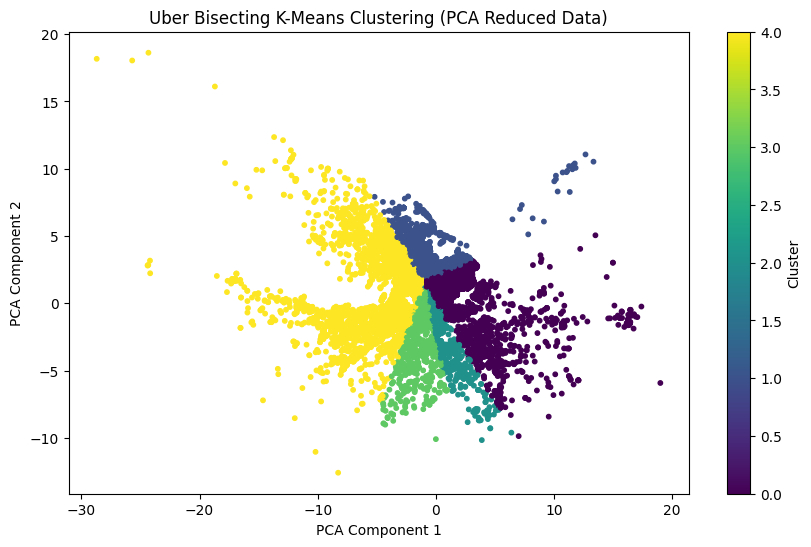

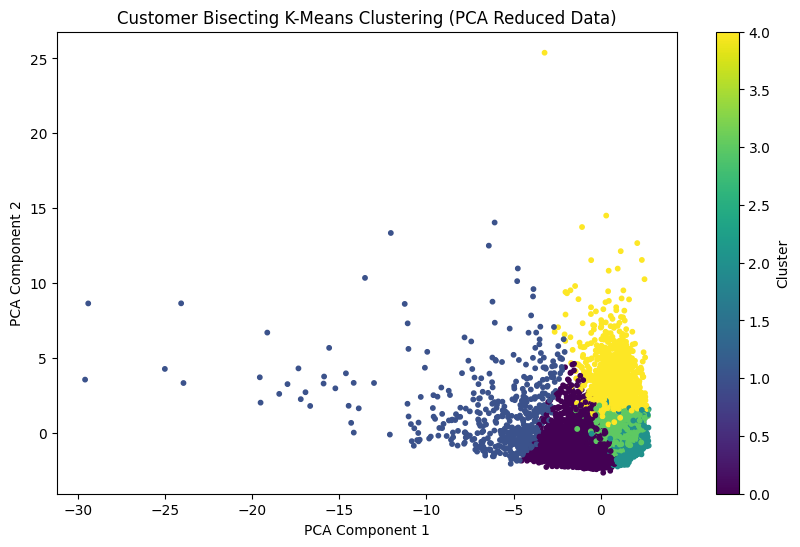

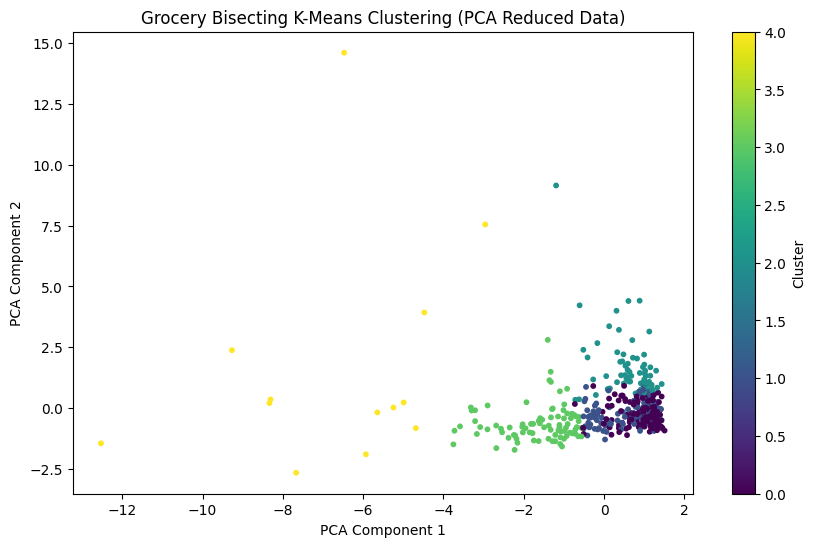

In [30]:
# Apply Bisecting K-Means clustering (re-running as Spark session was restarted)
from pyspark.ml.clustering import BisectingKMeans

bisecting_kmeans_uber = BisectingKMeans().setK(5).setSeed(1).setFeaturesCol('features')
model_bisecting_kmeans_uber = bisecting_kmeans_uber.fit(uber_preprocessed_df)
uber_bisecting_kmeans_predictions = model_bisecting_kmeans_uber.transform(uber_preprocessed_df)

bisecting_kmeans_customer = BisectingKMeans().setK(5).setSeed(1).setFeaturesCol('features')
model_bisecting_kmeans_customer = bisecting_kmeans_customer.fit(customer_preprocessed_df)
customer_bisecting_kmeans_predictions = model_bisecting_kmeans_customer.transform(customer_preprocessed_df)

bisecting_kmeans_grocery = BisectingKMeans().setK(5).setSeed(1).setFeaturesCol('features')
model_bisecting_kmeans_grocery = bisecting_kmeans_grocery.fit(grocery_preprocessed_df)
grocery_bisecting_kmeans_predictions = model_bisecting_kmeans_grocery.transform(grocery_preprocessed_df)


# Convert Uber PCA DataFrame with Bisecting K-Means predictions to Pandas
uber_pca_bisecting_pandas = uber_pca_df.alias("pca").join(uber_bisecting_kmeans_predictions.alias("bkmeans"), col("pca.id") == col("bkmeans.id")).select("pca.pca_features", "bkmeans.prediction").toPandas()

# Extract the first two components
uber_pca_bisecting_pandas['pca1'] = uber_pca_bisecting_pandas['pca_features'].apply(lambda x: x[0])
uber_pca_bisecting_pandas['pca2'] = uber_pca_bisecting_pandas['pca_features'].apply(lambda x: x[1])

# Create scatter plot for Uber dataset (Bisecting K-Means)
plt.figure(figsize=(10, 6))
plt.scatter(uber_pca_bisecting_pandas['pca1'], uber_pca_bisecting_pandas['pca2'], c=uber_pca_bisecting_pandas['prediction'], cmap='viridis', s=10)
plt.title("Uber Bisecting K-Means Clustering (PCA Reduced Data)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.colorbar(label='Cluster')
plt.show()

# Convert Customer PCA DataFrame with Bisecting K-Means predictions to Pandas
customer_pca_bisecting_pandas = customer_pca_df.alias("pca").join(customer_bisecting_kmeans_predictions.alias("bkmeans"), col("pca.id") == col("bkmeans.id")).select("pca.pca_features", "bkmeans.prediction").toPandas()

# Extract the first two components
customer_pca_bisecting_pandas['pca1'] = customer_pca_bisecting_pandas['pca_features'].apply(lambda x: x[0])
customer_pca_bisecting_pandas['pca2'] = customer_pca_bisecting_pandas['pca_features'].apply(lambda x: x[1])

# Create scatter plot for Customer dataset (Bisecting K-Means)
plt.figure(figsize=(10, 6))
plt.scatter(customer_pca_bisecting_pandas['pca1'], customer_pca_bisecting_pandas['pca2'], c=customer_pca_bisecting_pandas['prediction'], cmap='viridis', s=10)
plt.title("Customer Bisecting K-Means Clustering (PCA Reduced Data)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.colorbar(label='Cluster')
plt.show()

# Convert Grocery PCA DataFrame with Bisecting K-Means predictions to Pandas
grocery_pca_bisecting_pandas = grocery_pca_df.alias("pca").join(grocery_bisecting_kmeans_predictions.alias("bkmeans"), col("pca.id") == col("bkmeans.id")).select("pca.pca_features", "bkmeans.prediction").toPandas()

# Extract the first two components
grocery_pca_bisecting_pandas['pca1'] = grocery_pca_bisecting_pandas['pca_features'].apply(lambda x: x[0])
grocery_pca_bisecting_pandas['pca2'] = grocery_pca_bisecting_pandas['pca_features'].apply(lambda x: x[1])

# Create scatter plot for Grocery dataset (Bisecting K-Means)
plt.figure(figsize=(10, 6))
plt.scatter(grocery_pca_bisecting_pandas['pca1'], grocery_pca_bisecting_pandas['pca2'], c=grocery_pca_bisecting_pandas['prediction'], cmap='viridis', s=10)
plt.title("Grocery Bisecting K-Means Clustering (PCA Reduced Data)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.colorbar(label='Cluster')
plt.show()

## Visualize bisecting k-means clusters

### Subtask:
Plot the dimensionality-reduced data points for each dataset, colored by their Bisecting K-Means cluster assignments.


## Summary:

### Data Analysis Key Findings

*   Dimensionality reduction using PCA was successfully applied to the Uber, Customer, and Grocery datasets, reducing the feature space to 2 components.
*   Initial attempts to collect the large Uber Spark DataFrame to Pandas for plotting resulted in a `Py4JJavaError: java.lang.OutOfMemoryError: Java heap space`. This was resolved by increasing the Spark driver memory.
*   Adding a unique ID column and joining on this ID was necessary to correctly align PCA-reduced data with clustering predictions before converting to Pandas for plotting.
*   Scatter plots visualizing the K-Means clusters on the first two PCA components were successfully generated for all three datasets.
*   Bisecting K-Means clustering was successfully applied to all three datasets.
*   Scatter plots visualizing the Bisecting K-Means clusters on the first two PCA components were successfully generated for all three datasets.

### Insights or Next Steps

*   Visually comparing the K-Means and Bisecting K-Means scatter plots can provide insights into how the different clustering algorithms group the data points and how well-separated the clusters appear in the reduced 2D space for each dataset.
*   Further analysis could involve calculating cluster evaluation metrics (e.g., Silhouette score, WSSSE) for both K-Means and Bisecting K-Means on each dataset to quantitatively compare their performance, which cannot be solely judged by visual inspection of 2D plots.
